In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import os
import cv2
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
import numpy as np
import pandas as pd

Loading the Dataset

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print("Exception = ",e,img)
    return np.array(data)

In [3]:
train = get_training_data('./chest_xray/chest_xray/train')
test = get_training_data('./chest_xray/chest_xray/test')
val = get_training_data('./chest_xray/chest_xray/val')

Exception =  OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-2b5g8ysb\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
 .DS_Store
Exception =  OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-2b5g8ysb\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
 .DS_Store


a:\new_envss\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


Exception =  OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-2b5g8ysb\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
 .DS_Store
Exception =  OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-2b5g8ysb\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
 .DS_Store


In [4]:
train.shape

(5216, 2)

Data Visualization & Preprocessing

<AxesSubplot:ylabel='count'>

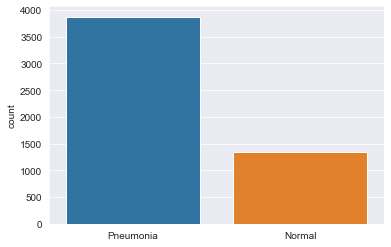

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

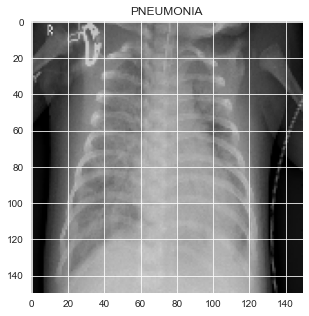

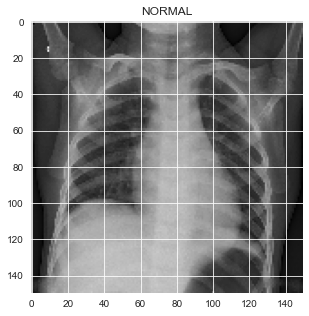

In [7]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [8]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

Normalize data ให้เป็นค่า 0 ถึง 1

In [9]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [10]:
x_train.shape

(5216, 150, 150)

เปลี่ยนมิติเพื่อใช้กับ CNN

In [11]:

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [12]:
x_train.shape

(5216, 150, 150, 1)

แก้ Data imbalance โดยการเพิ่ม weight

In [13]:
Testunique, Testcounts = np.unique(y_test, return_counts=True)
print("test count NORMAL and PNEUMONIA",Testunique,Testcounts)
unique, counts = np.unique(y_train, return_counts=True)
print("train count NORMAL and PNEUMONIA",unique,counts)

test count NORMAL and PNEUMONIA [0 1] [390 234]
train count NORMAL and PNEUMONIA [0 1] [3875 1341]


ใน train dataset มี 3875 sample ที่เป็น NORMAL และ 1341 sample ที่เป็น PNEUMONIA

In [14]:
COUNT_NORMAL = counts[0]
COUNT_PNEUMONIA = counts[1]
TRAIN_IMG_COUNT = counts[0]+counts[1]
VAL_IMG_COUNT = len(y_val)
VAL_IMG_COUNT

16

In [15]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [16]:
imgdecode =tf.convert_to_tensor(x_train,dtype=tf.int32)

Data Augmentation

In [17]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,
dtype=None)  # randomly flip images


datagen.fit(imgdecode)

In [18]:
datagen

Build model

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(150, 150, 1)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.3),
        dense_block(128, 0.2),
        dense_block(64, 0.1),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    

In [22]:
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 37, 37, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 18, 18, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 9, 9, 128)         27072     
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 128)        

เพิ่ม callbacks ,ลด learning_rate,Earlystop, ทำ checkpoint เก็บ ค่า weight ที่ดีที่สุด 

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
Earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

In [24]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 14 , 
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction,Earlystop,checkpoint_cb],
                   steps_per_epoch=TRAIN_IMG_COUNT // 32,
                    validation_steps=VAL_IMG_COUNT // 32,
                    class_weight=class_weight
                    
                   )
            


Train for 163 steps, validate for 1 steps
Epoch 1/14
163/163 [==============================] - 41s 249ms/step - loss: 0.4207 - accuracy: 0.8083 - val_loss: 0.8884 - val_accuracy: 0.5000
Epoch 2/14
163/163 [==============================] - 31s 190ms/step - loss: 0.2700 - accuracy: 0.9022 - val_loss: 1.1433 - val_accuracy: 0.5000
Epoch 3/14
162/163 [============================>.] - ETA: 0s - loss: 0.2375 - accuracy: 0.9078
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 32s 195ms/step - loss: 0.2377 - accuracy: 0.9078 - val_loss: 1.6597 - val_accuracy: 0.5000
Epoch 4/14
163/163 [==============================] - 31s 190ms/step - loss: 0.2021 - accuracy: 0.9231 - val_loss: 1.5383 - val_accuracy: 0.5000
Epoch 5/14
162/163 [============================>.] - ETA: 0s - loss: 0.1802 - accuracy: 0.9327
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [============================

In [25]:
result_eva = model.evaluate(x_test,y_test)
print("Loss of the model is - " , result_eva[0])
print("Accuracy of the model is - " , result_eva[1]*100 , "%")

624/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Loss of the model is -  0.26415147766088826
Accuracy of the model is -  90.06410241127014 %


Plot ผลการ train 

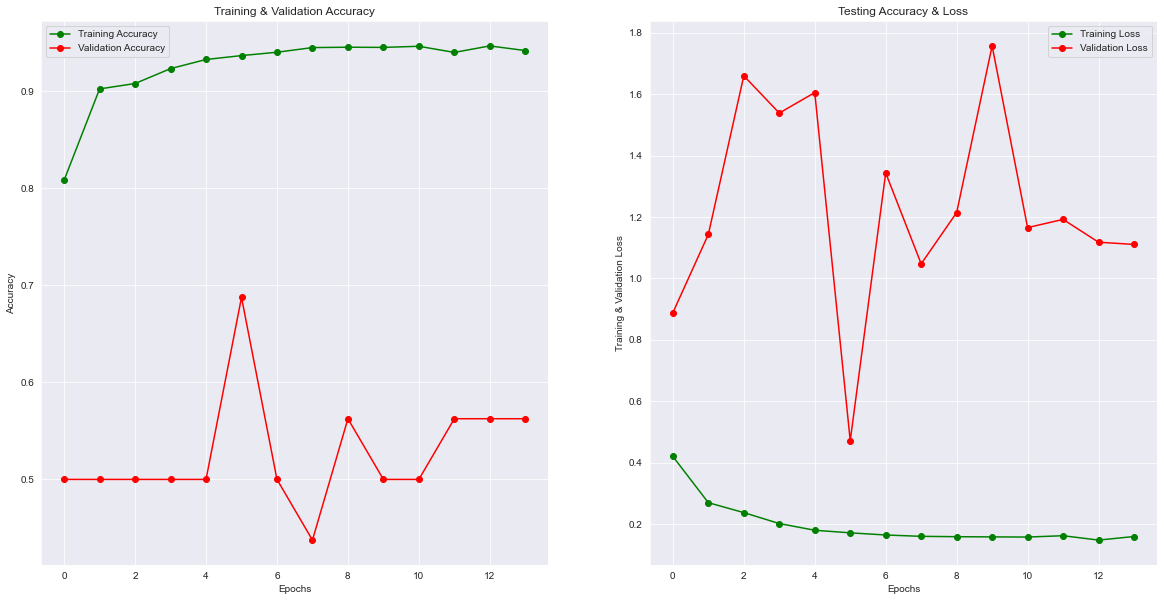

In [26]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)
epochs = [i for i in range(len(train_acc))]

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [27]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.88      0.97      0.92       390
   Normal (Class 1)       0.93      0.79      0.86       234

           accuracy                           0.90       624
          macro avg       0.91      0.88      0.89       624
       weighted avg       0.90      0.90      0.90       624



In [29]:
cm = confusion_matrix(y_test,predictions)
cm

array([[377,  13],
       [ 49, 185]], dtype=int64)

In [30]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

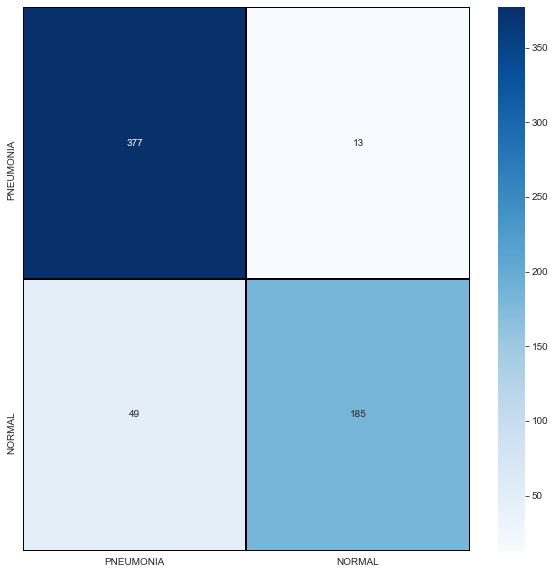

In [31]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [32]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

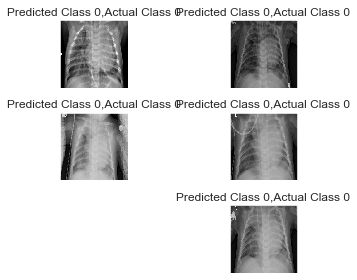

In [33]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

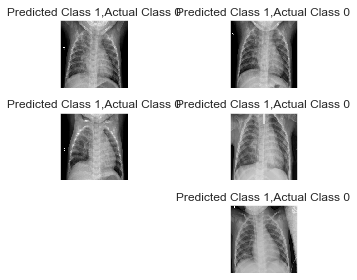

In [34]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1